In [33]:
# skeletal NCA model and trainer
# conda create -n ENVNAME python=3.11 pytorch torchvision torchaudio -c pytorch
# ipykernel

## Imports, common

In [34]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from dataclasses import dataclass
from IPython.display import display, clear_output

In [35]:
# kernels
identity = torch.tensor([[0, 0, 0], [0, 1, 0], [0, 0, 0]], dtype=torch.float32)
dx       = torch.tensor([[ 1, 2, 1], [ 0, 0, 0], [-1, -2, -1]], dtype=torch.float32) / 8.0
dy       = dx.T
avg      = torch.ones((3, 3), dtype=torch.float32) / 9.0
lap_5    = torch.tensor([[0, 1, 0], [1, -4, 1], [0, 1, 0]], dtype=torch.float32)
lap_9    = torch.tensor([[1, 2, 1], [2, -12, 2], [1, 2, 1]], dtype=torch.float32)

## NCA

In [36]:
class NCA(nn.Module):
    def __init__(self,
                 num_visible: int,
                 num_hidden: int,
                 device: torch.device,
                 fire_rate: float = 0.5,
                 alive_threshold: float = 0.1,
                 default_step_size: float = 1.0):
        super().__init__()
        self.num_visible = int(num_visible)
        self.num_hidden = int(num_hidden)
        self.num_channels = self.num_visible + self.num_hidden + 1  # + 1 for alpha

        self.device = device

        self.num_kernels = self.initialise_kernels()
        self.kernel_size = 3
        self.kernel_padding = 1
        self.stride = 1
        
        self.fire_rate = float(fire_rate)
        self.alive_threshold = float(alive_threshold)
        self.default_step_size = float(default_step_size)

        # CA update rule
        self.dmodel = nn.Sequential(
            nn.Conv2d(in_channels=self.num_channels * self.num_kernels,
                      out_channels=128, kernel_size=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=self.num_channels,
                      kernel_size=1, bias=False)
        )
        
        # initialise network
        with torch.no_grad():
            nn.init.xavier_uniform_(self.dmodel[0].weight)
            nn.init.zeros_(self.dmodel[0].bias)
            nn.init.zeros_(self.dmodel[-1].weight)

    def initialise_kernels(self):
        kernels_list = [identity, dx, dy]

        # stack all kernels into (num_kernels, 3, 3)
        kernels = torch.stack(kernels_list, dim=0)

        # expand for depthwise conv2d: (num_kernels * num_channels, 1, 3, 3)
        kernels = kernels.unsqueeze(1)                       # (nk, 1, 3, 3)
        kernels = kernels.repeat(self.num_channels, 1, 1, 1) # (nk * C, 1, 3, 3)
        kernels = kernels.to(self.device)                    # is this necessary?
        
        self.register_buffer("perception_kernels", kernels)
        
        return len(kernels_list)
    
    def get_living_mask(self, x):
        a = self.num_visible   # alpha channel follows the rgb/colour index channels
        alpha = x[:, a:a+1, :, :]
        alive = F.max_pool2d(
            alpha,
            kernel_size=self.kernel_size,
            stride=self.stride,
            padding=self.kernel_padding
        )
        return alive > self.alive_threshold

    def perceive(self, x):
        return F.conv2d(x, self.perception_kernels, padding=1, groups=self.num_channels)


    def forward(self, x, fire_rate=None, step_size=1.0, alpha_scale=1.0):
        pre_mask = self.get_living_mask(x)                 # find cells that are alive (or neighbouring alive cells)
        y = self.perceive(x)                               # get perception for all cells
        dx = self.dmodel(y) * step_size                    # predict update/delta for all cells (scaled by step_size)  # TODO: import step size from config

        # damp the alpha channel
        a = self.num_visible
        dx[:, a:a+1] = dx[:, a:a+1] * alpha_scale
        
        fire_rate = self.fire_rate if fire_rate is None else fire_rate
        update_mask = (torch.rand_like(x[:, :1, :, :]) <= fire_rate).float()  # random mask for updates

        x = x + dx * update_mask                           # apply delta to randomly selected cells

        post_mask = self.get_living_mask(x)                # find cells that are alive after the update
        life_mask = (pre_mask & post_mask).float()

        return x * life_mask                               # filter out dead cells


## Utilities

In [ ]:
def to_rgba(x, num_visible):
    # assumes first num_visible channels are visible (e.g., one-hot or RGB), last visible idx is alpha-1
    a = num_visible
    vis = x[:, :a]                       # (N, V, H, W)
    alpha = x[:, a:a+1]                  # (N, 1, H, W)
    return torch.cat([vis, alpha], dim=1)

def mse_rgba(x, target, num_visible):
    x_rgba = to_rgba(x, num_visible)
    tgt_rgba= to_rgba(target, num_visible)
    return ((x_rgba - tgt_rgba)**2).mean()

@torch.no_grad()
def rollout(model, x0, steps:int, **fwd_kwargs):
    xs = [x0]
    x = x0
    for _ in range(steps):
        x = model(x, **fwd_kwargs)
        xs.append(x)
    return xs  # list length steps+1

def make_target_from_image(img_tensor, num_visible):
    a = num_visible
    N, H, W = 1, img_tensor.size(-2), img_tensor.size(-1)
    target = torch.zeros(1, num_visible+1, H, W, dtype=img_tensor.dtype, device=img_tensor.device)
    target[:, :a] = img_tensor.unsqueeze(0)
    target[:, a]  = 1.0  # opaque
    return target

@torch.no_grad()
def seed(num_channels:int, alpha_idx:int, batch:int, h:int, w:int, device=None):
    x = torch.zeros(batch, num_channels, h, w, dtype=torch.float32, device=device)
    x[:, alpha_idx, h//2, w//2] = 1.0
    return x

In [38]:
# little renderer
import math
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F

def _checkerboard(h, w, cell=8, a=0.8, b=0.9, device=None):
    yy, xx = torch.meshgrid(torch.arange(h, device=device), torch.arange(w, device=device), indexing='ij')
    cb = ((yy // cell + xx // cell) % 2).float()
    return cb * a + (1 - cb) * b  # grayscale background in [0,1]

@torch.no_grad()
def render_rgba(sample: torch.Tensor, num_visible: int, bg_cell=8):
    """
    sample: (C, H, W) with first num_visible channels = visible (e.g., RGB),
            and channel num_visible = alpha (1 channel).
    Returns: (H, W, 3) numpy array in [0,1]
    """
    C, H, W = sample.shape
    a_idx = num_visible
    rgb  = sample[:a_idx]               # (V,H,W) -> assume V=3 for RGB; if one-hot, adapt as needed
    if rgb.shape[0] == 1:               # grayscale -> RGB
        rgb = rgb.repeat(3, 1, 1)
    elif rgb.shape[0] > 3:
        rgb = rgb[:3]                   # take first 3 visible channels for preview
    alpha = sample[a_idx:a_idx+1].clamp(0, 1)

    bg = _checkerboard(H, W, cell=bg_cell, device=sample.device)
    bg = bg.expand(3, H, W)

    out = rgb.clamp(0,1) * alpha + bg * (1 - alpha)
    return out.permute(1,2,0).detach().cpu().numpy()

@torch.no_grad()
def plot_rollout(model, x0, steps, num_visible: int, frames=6, title=None, step_kwargs=None):
    """
    Shows a row of 'frames' images sampled across a rollout of length 'steps'.
    """
    step_kwargs = step_kwargs or {}
    # collect sequence
    xs = [x0]
    x  = x0
    for _ in range(steps):
        x = model(x, **step_kwargs)
        xs.append(x)

    # pick evenly spaced frames
    idxs = torch.linspace(0, steps, frames+1, dtype=torch.int64)  # +1 because xs has steps+1
    idxs = torch.unique(idxs)  # just in case frames > steps
    imgs = []
    for i in idxs:
        sample = xs[i][0]  # take first in batch (C,H,W)
        imgs.append(render_rgba(sample, num_visible))

    # plot
    cols = len(imgs)
    plt.figure(figsize=(2.8*cols, 2.8))
    for c, im in enumerate(imgs, 1):
        ax = plt.subplot(1, cols, c)
        ax.imshow(im)
        ax.set_axis_off()
        ax.set_title(f"t={int(idxs[c-1])}")
    if title:
        plt.suptitle(title, y=1.02)
    plt.tight_layout()
    plt.show()

import math
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F

def _checkerboard(h, w, cell=8, a=0.8, b=0.9, device=None):
    yy, xx = torch.meshgrid(torch.arange(h, device=device), torch.arange(w, device=device), indexing='ij')
    cb = ((yy // cell + xx // cell) % 2).float()
    return cb * a + (1 - cb) * b  # grayscale background in [0,1]

@torch.no_grad()
def render_rgba(sample: torch.Tensor, num_visible: int, bg_cell=8):
    """
    sample: (C, H, W) with first num_visible channels = visible (e.g., RGB),
            and channel num_visible = alpha (1 channel).
    Returns: (H, W, 3) numpy array in [0,1]
    """
    C, H, W = sample.shape
    a_idx = num_visible
    rgb  = sample[:a_idx]               # (V,H,W) -> assume V=3 for RGB; if one-hot, adapt as needed
    if rgb.shape[0] == 1:               # grayscale -> RGB
        rgb = rgb.repeat(3, 1, 1)
    elif rgb.shape[0] > 3:
        rgb = rgb[:3]                   # take first 3 visible channels for preview
    alpha = sample[a_idx:a_idx+1].clamp(0, 1)

    bg = _checkerboard(H, W, cell=bg_cell, device=sample.device)
    bg = bg.expand(3, H, W)

    out = rgb.clamp(0,1) * alpha + bg * (1 - alpha)
    return out.permute(1,2,0).detach().cpu().numpy()

@torch.no_grad()
def plot_rollout(model, x0, steps, num_visible: int, frames=6, title=None, step_kwargs=None):
    """
    Shows a row of 'frames' images sampled across a rollout of length 'steps'.
    """
    step_kwargs = step_kwargs or {}
    # collect sequence
    xs = [x0]
    x  = x0
    for _ in range(steps):
        x = model(x, **step_kwargs)
        xs.append(x)

    # pick evenly spaced frames
    idxs = torch.linspace(0, steps, frames+1, dtype=torch.int64)  # +1 because xs has steps+1
    idxs = torch.unique(idxs)  # just in case frames > steps
    imgs = []
    for i in idxs:
        sample = xs[i][0]  # take first in batch (C,H,W)
        imgs.append(render_rgba(sample, num_visible))

    # plot
    cols = len(imgs)
    plt.figure(figsize=(2.8*cols, 2.8))
    for c, im in enumerate(imgs, 1):
        ax = plt.subplot(1, cols, c)
        ax.imshow(im)
        ax.set_axis_off()
        ax.set_title(f"t={int(idxs[c-1])}")
    if title:
        plt.suptitle(title, y=1.02)
    plt.tight_layout()
    plt.show()

def make_vis_callback(num_visible: int, steps=64, frames=6, every=50, step_kwargs=None):
    step_kwargs = step_kwargs or {}
    def _cb(iter_idx: int, x: torch.Tensor, loss: torch.Tensor, model: torch.nn.Module):
        if iter_idx % every == 0:
            title = f"iter {iter_idx} | loss={loss.item():.5f}"
            plot_rollout(model, x0=x.detach().clone(), steps=steps,
                         num_visible=num_visible, frames=frames,
                         title=title, step_kwargs=step_kwargs)
    return _cb

def make_live_vis(num_visible: int, steps=64, frames=6, every=50, step_kwargs=None):
    step_kwargs = step_kwargs or {}
    fig, axarr = None, None

    @torch.no_grad()
    def rollout_images(model, x0, steps, frames):
        xs = [x0]
        x  = x0
        for _ in range(steps):
            x = model(x, **step_kwargs)
            xs.append(x)
        idxs = torch.linspace(0, steps, frames+1, dtype=torch.int64)
        imgs = [render_rgba(xs[i][0], num_visible) for i in idxs]
        return imgs, idxs

    def _cb(iter_idx: int, x: torch.Tensor, loss: torch.Tensor, model: torch.nn.Module):
        if iter_idx % every != 0:
            return
        imgs, idxs = rollout_images(model, x.detach().clone(), steps, frames)

        clear_output(wait=True)
        nonlocal fig, axarr
        cols = len(imgs)
        if fig is None:
            fig, axarr = plt.subplots(1, cols, figsize=(2.8*cols, 2.8))
        for ax, im, t in zip(axarr, imgs, idxs.tolist()):
            ax.clear()
            ax.imshow(im)
            ax.set_axis_off()
            ax.set_title(f"t={int(t)}")

        fig.suptitle(f"iter {iter_idx} | loss={loss.item():.5f}")
        plt.tight_layout()
        display(fig)     # <- actually pushes the image
        plt.pause(0.001) # <- yields control to the UI loop

    return _cb

## Trainer

In [39]:
@dataclass
class TrainCfg:
    steps_per_iter: int = 64          # unroll BPTT steps
    fire_rate: float = 0.5
    step_size: float = 1.0
    alpha_scale: float = 1.0
    lr: float = 1e-3
    grad_clip: float = 1.0

class Trainer:
    def __init__(self, model:NCA, target:torch.Tensor, cfg:TrainCfg, device=None, on_iter=None):
        self.model = model.to(device or torch.device('cpu'))
        self.target = target.to(next(model.parameters()).device)
        self.cfg = cfg
        self.opt = torch.optim.Adam(self.model.parameters(), lr=cfg.lr)
        self.on_iter = on_iter  # callback for visualisations


    def train_step(self, x, iter_idx: int = 0):
        self.model.train()
        for _ in range(self.cfg.steps_per_iter):
            x = self.model(x, fire_rate=self.cfg.fire_rate,
                              step_size=self.cfg.step_size,
                              alpha_scale=self.cfg.alpha_scale)
        loss = mse_rgba(x, self.target, self.model.num_visible)

        self.opt.zero_grad(set_to_none=True)
        loss.backward()

        # normalise gradients
        with torch.no_grad():
            for p in self.model.parameters():
                if p.grad is not None:
                    # denom = p.grad.norm().clamp_min(1e-8)
                    denom = p.grad.norm() + 1e-8
                    p.grad.div_(denom)

        self.opt.step()

        if self.on_iter is not None:
            self.on_iter(iter_idx, x, loss, self.model)

        return x.detach(), loss.detach()


## Run!

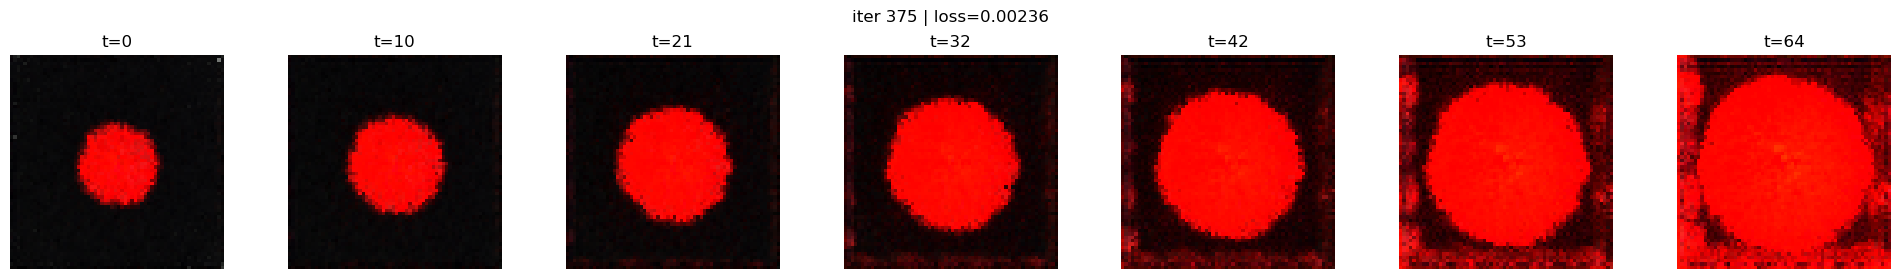

<Figure size 640x480 with 0 Axes>

iter 380: loss=0.00277
iter 390: loss=0.00228


KeyboardInterrupt: 

In [40]:
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('mps')

model = NCA(num_visible=3, num_hidden=16, device=device)  # RGB + 16 hidden + alpha
model.to(device)

vis_cb = make_live_vis(
    num_visible=model.num_visible,
    steps=64, frames=6, every=25,
    step_kwargs=dict(fire_rate=0.5, step_size=1.0, alpha_scale=0.5)
)

H, W = 64, 64
x0 = seed(model.num_channels, model.num_visible, batch=8, h=H, w=W, device=device)

# dummy target: small colored disk
yy, xx = torch.meshgrid(torch.arange(H, device=device), torch.arange(W, device=device), indexing='ij')
mask = ((xx-W//2)**2 + (yy-H//2)**2) < (H*0.18)**2
target_rgb = torch.zeros(3, H, W, device=device)
target_rgb[0, mask] = 1.0  # red disk
target = make_target_from_image(target_rgb, num_visible=3)

cfg = TrainCfg(steps_per_iter=64, lr=2e-3, fire_rate=0.5, step_size=1.0, alpha_scale=0.5)
trainer = Trainer(model, target, cfg, device=device, on_iter=vis_cb)

x = x0
for i in range(500):
    x, loss = trainer.train_step(x0, iter_idx=i)
    if i % 10 == 0:
        print(f"iter {i}: loss={loss.item():.5f}")
